In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch import optim, nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.utils import make_grid
from torchvision import transforms as T
from torchvision import models
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report, confusion_matrix
from torchmetrics import Accuracy
from torchsummary import summary
from tqdm.notebook import tqdm
torch.manual_seed(27)
np.random.seed(27)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.get_device_properties('cuda')

_CudaDeviceProperties(name='NVIDIA GeForce GTX 1050 Ti', major=6, minor=1, total_memory=4096MB, multi_processor_count=6)

In [2]:
!nvidia-smi

Wed May 26 11:52:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 466.27       Driver Version: 466.27       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   56C    P8    N/A /  N/A |     78MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
transforms = {
    'train' : T.Compose([
    T.Resize(size=(224,224)),
    T.RandomAffine(30),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                        ]),
    
    'valid' : T.Compose([
    T.Resize(size=(224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                        ])
}

In [4]:
datasets = {
    'train' : ImageFolder('chest_xray/train/', transform=transforms['train']),
    'valid' : ImageFolder('chest_xray/test/', transform=transforms['valid']),
}

In [5]:
test_idx, valid_idx = train_test_split(np.arange(len(datasets['valid'])), test_size=.5, stratify=datasets['valid'].targets)

In [6]:
batch_size = 16
test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
dataloaders = {
    'train' : DataLoader(dataset=datasets['train'], batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=True),
    'test' : DataLoader(dataset=datasets['valid'], batch_size=batch_size, sampler=test_sampler, num_workers=2, pin_memory=True),
    'valid' : DataLoader(dataset=datasets['valid'], sampler=valid_sampler, batch_size=batch_size, num_workers=2, pin_memory=True)
}

In [7]:
trues_test = np.array(dataloaders['test'].dataset.targets)
trues_valid = np.array(dataloaders['valid'].dataset.targets)
trues_train = np.array(dataloaders['train'].dataset.targets)
print(f'Train Samples : {len(trues_train)}\tTest Samples : {len(trues_test)}\tValid Samples : {len(trues_valid)}')
print(f'Train Normal Ration : {round(sum(trues_train==0)/len(trues_train), 5)}\tTest Pneumonia Ration : {round(sum(trues_train==1)/len(trues_train), 5)}')
print(f'Test Normal Ration : {round(sum(trues_test[test_idx]==0)/len(test_idx), 5)}\tTest Pneumonia Ration : {round(sum(trues_test[test_idx]==1)/len(test_idx), 5)}')
print(f'Valid Normal Ration : {round(sum(trues_valid[valid_idx]==0)/len(valid_idx), 5)}\tValid Pneumonia Ration : {round(sum(trues_valid[valid_idx]==1)/len(valid_idx), 5)}')

Train Samples : 5232	Test Samples : 624	Valid Samples : 624
Train Normal Ration : 0.25784	Test Pneumonia Ration : 0.74216
Test Normal Ration : 0.375	Test Pneumonia Ration : 0.625
Valid Normal Ration : 0.375	Valid Pneumonia Ration : 0.625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


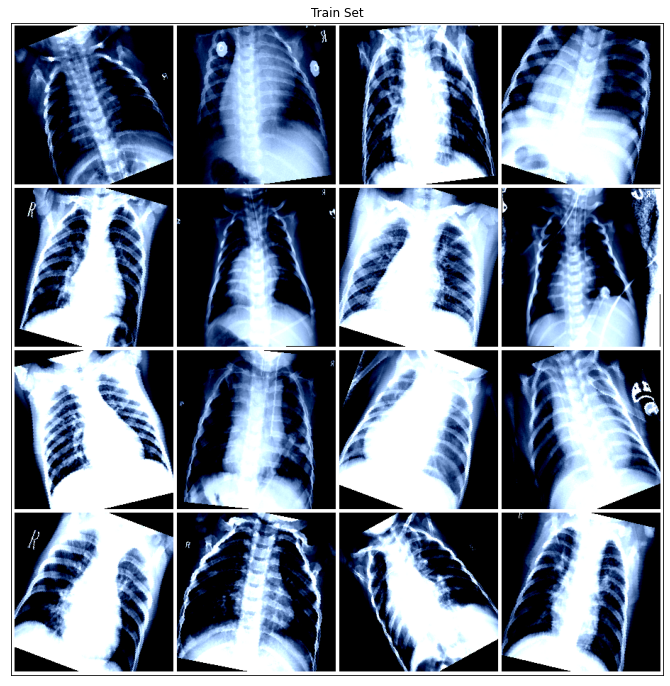

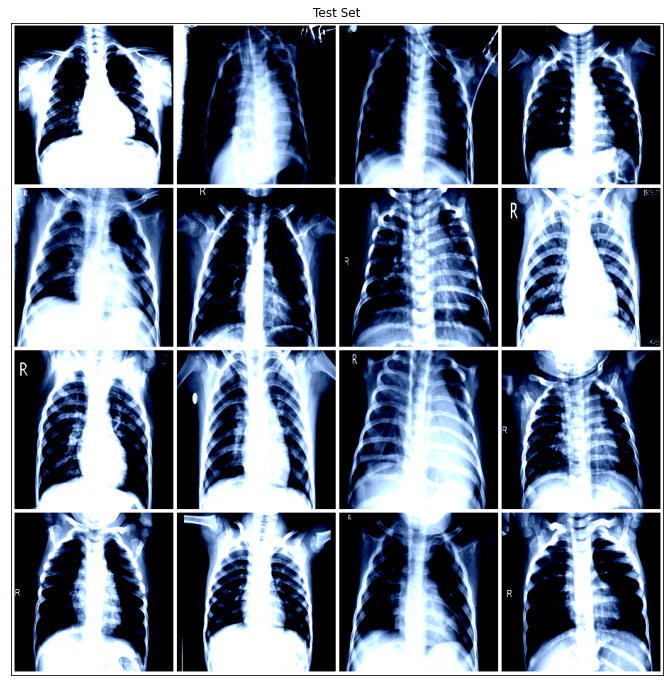

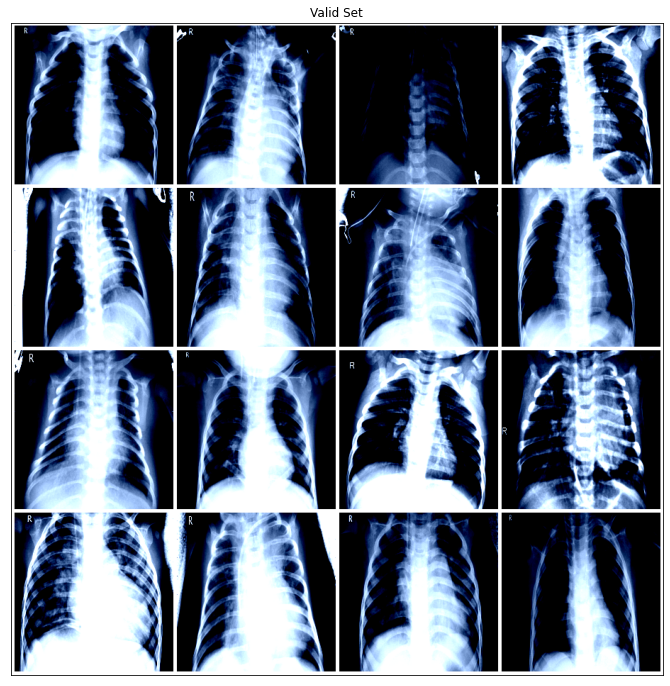

In [8]:
for x, y in dataloaders['train']:
    plt.figure(figsize=(12,12))
    plt.xticks([]); plt.yticks([])
    plt.title('Train Set')
    plt.imshow(make_grid(x, nrow=4, padding=5, pad_value=1).permute(1,2,0))
    break

for x, y in dataloaders['test']:
    plt.figure(figsize=(12,12))
    plt.xticks([]); plt.yticks([])
    plt.title('Test Set')
    plt.imshow(make_grid(x, nrow=4, padding=5, pad_value=1).permute(1,2,0))
    break
    
for x, y in dataloaders['valid']:
    plt.figure(figsize=(12,12))
    plt.xticks([]); plt.yticks([])
    plt.title('Valid Set')
    plt.imshow(make_grid(x, nrow=4, padding=5, pad_value=1).permute(1,2,0))
    break

In [9]:
def fit(model, loader, optimizer, loss, epochs=5):
    TL, TA, VL, VA =[], [], [], []
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    train_metric = Accuracy().to(device)
    valid_metric = Accuracy().to(device)
    
    for epoch in tqdm(range(epochs), desc='Epochs', leave=True):
        
        model.train()
        cst = 0
        for x, y in tqdm(loader['train'], desc='Train Step'):
            x = x.to(device)
            y = y.to(device)
            preds = model(x).to(device)
            acc = train_metric(preds, y)
            cost = loss(preds, y)
            cst += cost.item()
            cost.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cst /= len(loader['train'])
        TL.append(cst)
        TA.append(train_metric.compute().item())
        print(f"TL : {cst}\tTA : {train_metric.compute()}")
        model.eval()
        cst = 0
        for x, y in tqdm(loader['valid'], desc='Valid Step'):
            x = x.to(device)
            y = y.to(device)
            preds = model(x).to(device)
            acc = valid_metric(preds, y)
            cost = loss(preds, y)
            cst += cost.item()
        
        cst /= len(loader['valid'])
        VL.append(cst)
        VA.append(valid_metric.compute().item())
        print(f"VL : {cst}\tVA : {valid_metric.compute()}")
        
    plt.figure(figsize=(20, 7))
    plt.subplot(121)
    plt.plot(TL, '-xr', VL, '-xg')
    plt.title('Cost Curve')
    plt.legend(['Train Loss', 'Valid Loss'])
    plt.subplot(122)
    plt.plot(TA, '-xr', VA, '-xg')
    plt.title('Accuracy Curve')
    plt.legend(['Train Acc', 'Valid Acc'])
    plt.tight_layout()
    plt.grid(True)
        
    return model

In [10]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(
    nn.Dropout(),
    nn.Linear(model.fc.in_features, 2),
    nn.Softmax(dim=1)
)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
lr = 3e-3
weight_decay = 1e-4
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=lr, weight_decay=weight_decay)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train Step:   0%|          | 0/327 [00:00<?, ?it/s]

TL : 0.5642792159628796	TA : 0.7461773753166199


Valid Step:   0%|          | 0/20 [00:00<?, ?it/s]

VL : 0.4471342533826828	VA : 0.8685897588729858


Train Step:   0%|          | 0/327 [00:00<?, ?it/s]

TL : 0.4461634221062383	TA : 0.8026567101478577


Valid Step:   0%|          | 0/20 [00:00<?, ?it/s]

VL : 0.43006854951381684	VA : 0.8733974099159241


Train Step:   0%|          | 0/327 [00:00<?, ?it/s]

TL : 0.4254155938231617	TA : 0.8297655582427979


Valid Step:   0%|          | 0/20 [00:00<?, ?it/s]

VL : 0.42515145242214203	VA : 0.877136766910553


Train Step:   0%|          | 0/327 [00:00<?, ?it/s]

TL : 0.42422334726797334	TA : 0.8431766033172607


Valid Step:   0%|          | 0/20 [00:00<?, ?it/s]

VL : 0.4392478585243225	VA : 0.875


Train Step:   0%|          | 0/327 [00:00<?, ?it/s]

TL : 0.4282245600442274	TA : 0.8504587411880493


Valid Step:   0%|          | 0/20 [00:00<?, ?it/s]

VL : 0.42288741618394854	VA : 0.8775641322135925


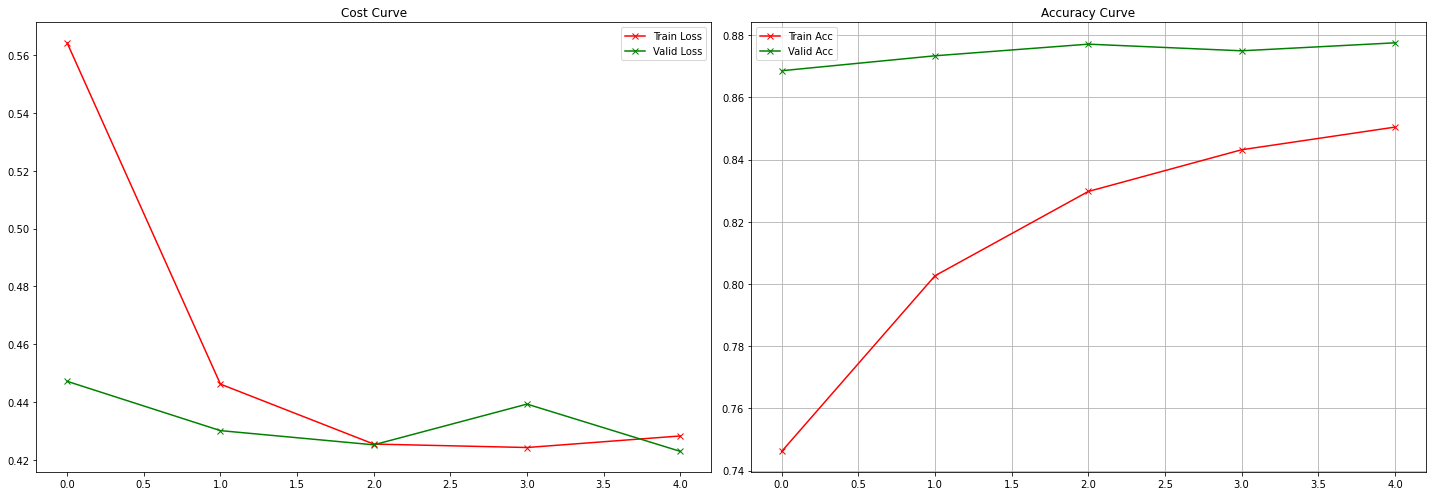

In [12]:
md = fit(model, dataloaders, optimizer, loss, epochs=5)

In [13]:
print('---------------------------Train Classification Report---------------------------')
md.train()
p, t = [], []
metric = Accuracy().to(device)
cst = 0
for x, y in tqdm(dataloaders['train'], desc='Test Step'):
    x = x.to(device)
    y = y.to(device)
    preds = model(x).to(device)
    p += preds.argmax(dim=1).detach().cpu().tolist()
    t += y.detach().cpu().tolist()
    acc = metric(preds, y)
    cost = loss(preds, y)
    cst += cost.item()
acc = metric.compute()
p, t = np.array(p), np.array(t)
print(classification_report(t, p))

---------------------------Train Classification Report---------------------------


Test Step:   0%|          | 0/327 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.74      0.86      0.79      1349
           1       0.95      0.89      0.92      3883

    accuracy                           0.89      5232
   macro avg       0.84      0.88      0.86      5232
weighted avg       0.89      0.89      0.89      5232



In [14]:
print('---------------------------Valid Classification Report---------------------------')
md.eval()
p, t = [], []
metric = Accuracy().to(device)
cst = 0
for x, y in tqdm(dataloaders['valid'], desc='Test Step'):
    x = x.to(device)
    y = y.to(device)
    preds = model(x).to(device)
    p += preds.argmax(dim=1).detach().cpu().tolist()
    t += y.detach().cpu().tolist()
    acc = metric(preds, y)
    cost = loss(preds, y)
    cst += cost.item()
acc = metric.compute()
p, t = np.array(p), np.array(t)
print(classification_report(t, p))

---------------------------Valid Classification Report---------------------------


Test Step:   0%|          | 0/20 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.84      0.81      0.83       117
           1       0.89      0.91      0.90       195

    accuracy                           0.87       312
   macro avg       0.87      0.86      0.86       312
weighted avg       0.87      0.87      0.87       312



In [15]:
print('---------------------------Test Classification Report---------------------------')
md.eval()
p, t = [], []
metric = Accuracy().to(device)
cst = 0
for x, y in tqdm(dataloaders['test'], desc='Test Step'):
    x = x.to(device)
    y = y.to(device)
    preds = model(x).to(device)
    p += preds.argmax(dim=1).detach().cpu().tolist()
    t += y.detach().cpu().tolist()
    acc = metric(preds, y)
    cost = loss(preds, y)
    cst += cost.item()
acc = metric.compute()
p, t = np.array(p), np.array(t)
print(classification_report(t, p))

---------------------------Test Classification Report---------------------------


Test Step:   0%|          | 0/20 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.93      0.80      0.86       117
           1       0.89      0.96      0.93       195

    accuracy                           0.90       312
   macro avg       0.91      0.88      0.89       312
weighted avg       0.91      0.90      0.90       312

